<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Machine%20Learning%20Methods/ML_Airline_No_Differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will learn how to apply machine learning, two time series forecasting, we'll
use the airline passengers data, which has been our standard benchmark throughout this course.

So the main idea is that we're going to have two versions of this script.

In this version, we will **not use differencing**.

We already know why this is suboptimal, but we're going to do it anyway just to see if it will work.

This will also help us get familiar with the basic structure of this code without having to worry about differencing.

Remember that **when you difference your data, you make it stationary**, which is good.

But when you want to** make a forecast, you then have to undo this different thing, which is non-trivial**.

Now, libraries like stats, models do all that work for you, but because we're now using generic machine learning methods, we'll need to do it ourselves.

So in order to introduce only one concept at a time, we'll save differencing for the next script.

In this script, we'll test the belief that **machine learning can extrapolate**.

Well, we kind of already know it can't, but this will help us to confirm what we saw before.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pip install -U scikit-learn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])
df.head()

,Passengers,LogPassengers
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


In [ ]:
Ntest=12 #Ntest = 12, cause we want to process by month
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# Make supervised dataset
# Lets see if we can use T pas values to predict the next value

series = df['LogPassengers'].to_numpy()
series

array([4.71849887, 4.77068462, 4.88280192, 4.8598124 , 4.79579055,
       4.90527478, 4.99721227, 4.99721227, 4.91265489, 4.77912349,
       4.6443909 , 4.77068462, 4.74493213, 4.83628191, 4.94875989,
       4.90527478, 4.82831374, 5.00394631, 5.13579844, 5.13579844,
       5.06259503, 4.89034913, 4.73619845, 4.94164242, 4.97673374,
       5.01063529, 5.18178355, 5.0937502 , 5.14749448, 5.18178355,
       5.29330482, 5.29330482, 5.21493576, 5.08759634, 4.98360662,
       5.11198779, 5.14166356, 5.19295685, 5.26269019, 5.19849703,
       5.20948615, 5.38449506, 5.43807931, 5.48893773, 5.34233425,
       5.25227343, 5.14749448, 5.26785816, 5.27811466, 5.27811466,
       5.46383181, 5.45958551, 5.433722  , 5.49306144, 5.5759491 ,
       5.60580207, 5.46806014, 5.35185813, 5.19295685, 5.30330491,
       5.31811999, 5.23644196, 5.45958551, 5.42495002, 5.45532112,
       5.5759491 , 5.71042702, 5.68017261, 5.55682806, 5.433722  ,
       5.31320598, 5.433722  , 5.48893773, 5.45103845, 5.58724

In [ ]:
T = 10
x = []
y = []
for t in range(len(series) - T):
  X = series[t:t+T]
  x.append(X)
  Y = series[t+T]
  y.append(Y)

x = np.array(x).reshape(-1, T)
y = np.array(y)
N = len(x)
print('x.shape', x.shape, "y.shape", y.shape)

x.shape (134, 10) y.shape (134,)


In [ ]:
xtrain, ytrain = x[:-Ntest], y[:-Ntest] # x[:-Ntest] => x is 134, Ntest is 12. So 134-12
xtest, ytest = x[-Ntest:], y[-Ntest:]

In [ ]:
len(xtrain)

122

### **Linear Regression**

In [ ]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
print ("R2 Score for Linear Regression is(Train):")
lr.score(xtrain, ytrain)

R2 Score for Linear Regression is:


0.9599443783339898

We get an R-squared of about 0.959, which seems pretty good

In [ ]:
print('R2 Score for Linear Regression is(Test):')
lr.score(xtest, ytest)

R2 Score for Linear Regression is(Test):


0.6910953044565602

Next step is to **create boolean arrays**, to index both the train and testsets. Note that because we are using **big T** lag's in our model, we won't be able to make predictions for the first big T values.

So we'll set the first big T values of train_idx reacts to false.

This kind of thing should give you a better idea of how statsmodels works behind the scenes, since
it has to contend with the same details.

In [ ]:
# Boolean Index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False #first T values are not predictable

Next step is to assign our one step forecasts to the data frame

#### **1-Step Forecast**

In [ ]:
# 1-Step Forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(xtest)

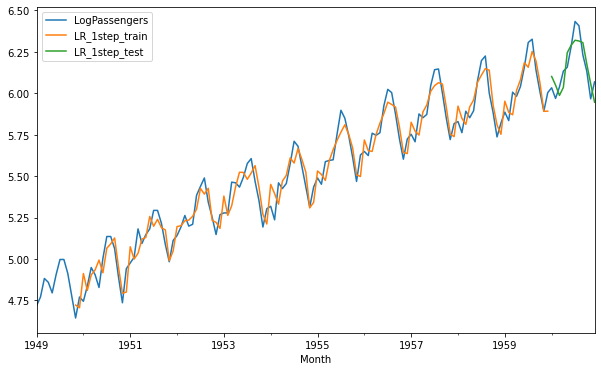

In [ ]:
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(10, 6))

Notice how our model seems to underestimate the peaks

#### **Multi-Step Forecast**

Next step is to compute a **multi-step forecas**t.

So remember that `statsmodels` does not compute a `one step forecast`.
It only computes a multi-step forecast.

So this code is closer to what we were doing before when we looked at **ARIMA** and **ETF**

In [ ]:
# multi-step forecast
multistep_predictions = [] #creating an empty list to store our predictions

# first test input
# first step is to obtain the first test input, 
# which is just X test indexed at zero.
last_x = xtest[0]

# enter a loop that will continue as long as our list of 
# predictions is shorter than and test
while len(multistep_predictions) < Ntest:
  # Inside the loop, we'll call the predicate function to get a prediction.
  p = lr.predict(last_x.reshape(1, -1))[0] #reshape last_x array #index zero[0] for get only one prediction

  # update the prediction list
  # append our prediction to a list of predictions
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1) #update last_x for the next iteration of the loop.
  last_x[-1] = p

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

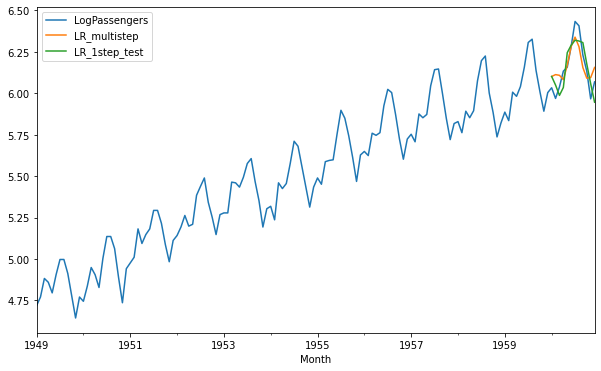

In [ ]:
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(10, 6))

The multi-step forecast seems to be a little worse compared to the ones that forecast.

#### **Multioutput Forecast**

Next step in this notebook is to create a multi output model, so in order to build this, it's really just a matter of creating the right data set

In [ ]:
# Make multi output supervised dataset

Tx = T #represents the number of time steps in the input
Ty = Ntest #represents the number of steps in the output
x = []
y = []
for t in range(len(series) - Tx - Ty + 1): #limit for this loop
  X = series[t:t+Tx] #input series
  x.append(X)
  Y = series[t+Tx:t+Tx+Ty] #output series
  y.append(Y)

x = np.array(x).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)
# we convert X and Y into numpy array
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (123, 10) y.shape (123, 12)


In [ ]:
x

array([[4.71849887, 4.77068462, 4.88280192, ..., 4.99721227, 4.91265489,
        4.77912349],
       [4.77068462, 4.88280192, 4.8598124 , ..., 4.91265489, 4.77912349,
        4.6443909 ],
       [4.88280192, 4.8598124 , 4.79579055, ..., 4.77912349, 4.6443909 ,
        4.77068462],
       ...,
       [5.88610403, 5.83481074, 6.00635316, ..., 6.32614947, 6.13772705,
        6.00881319],
       [5.83481074, 6.00635316, 5.98141421, ..., 6.13772705, 6.00881319,
        5.89164421],
       [6.00635316, 5.98141421, 6.04025471, ..., 6.00881319, 5.89164421,
        6.00388707]])

In [ ]:
xtrain_m, ytrain_m = x[:-1], y[:-1]
xtest_m, ytest_m = x[-1:], y[-1:]

In [ ]:
xtrain_m

array([[4.71849887, 4.77068462, 4.88280192, ..., 4.99721227, 4.91265489,
        4.77912349],
       [4.77068462, 4.88280192, 4.8598124 , ..., 4.91265489, 4.77912349,
        4.6443909 ],
       [4.88280192, 4.8598124 , 4.79579055, ..., 4.77912349, 4.6443909 ,
        4.77068462],
       ...,
       [5.82008293, 5.88610403, 5.83481074, ..., 6.30627529, 6.32614947,
        6.13772705],
       [5.88610403, 5.83481074, 6.00635316, ..., 6.32614947, 6.13772705,
        6.00881319],
       [5.83481074, 6.00635316, 5.98141421, ..., 6.13772705, 6.00881319,
        5.89164421]])

In [ ]:
lr = LinearRegression()
lr.fit(xtrain_m, ytrain_m)
print('R2 Score for Linear Regression is(Train/Multioutput): ')
lr.score(xtrain_m, ytrain_m)

R2 Score for Linear Regression is(Train/Multioutput): 


0.9734607773512528

In [ ]:
# SST is Zero
print('R2 Score for Linear Regression is(Test/Multioutput): ')
lr.score(xtest_m, ytest_m)

R2 Score for Linear Regression is(Test/Multioutput): 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

When we tried to compute the R squared of the test, we get not a number.

So why does this happen?

Well, recall that the R squared involves computing the SST, which is essentially the sample variance of the targets, but the sample variance of a single sample is zero since we only have one test data point.

So unfortunately, the test R squared cannot be computed this way.


In [ ]:
r2_score(lr.predict(xtest_m).flatten(), ytest_m.flatten())

0.8018749676715189

In [ ]:
df.loc[test_idx, 'LR_multioutput'] = lr.predict(xtest_m).flatten()

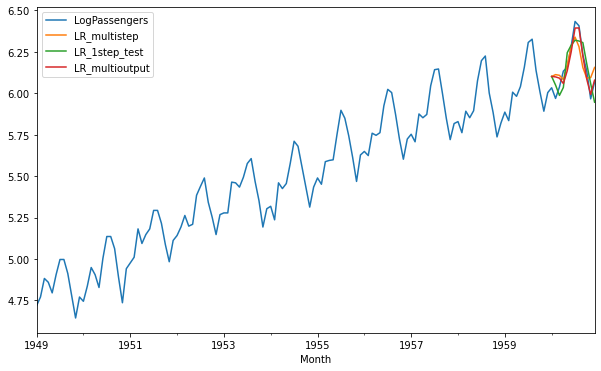

In [ ]:
# plot all forecast
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(10, 6))

It looks like the multiple forecast is superior

In [ ]:
# Use Different Metrics
#MAPE
mape1 = mean_absolute_percentage_error(ytest, multistep_predictions)
print('Multi-Step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(
    ytest, df.loc[test_idx, 'LR_Multioutput']
)
print('Multi-Output MAPE:', mape2)

Multi-Step MAPE: 0.012229325023475299
Multi-Output MAPE: 0.007178924475039815


### TEST OTHER MODELS

In [ ]:
def one_step_multistep_forecast(model, name):
  model.fit(xtrain, ytrain)
  print("One-step forecast:", name)
  # print('Train R^2:', model.score(xtrain, ytrain))
  # print('Test R^2 (1-Step):', model.score(xtest, ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(ytest, multistep_predictions)
  print('Test MAPE (Multi-Step):', mape)

  # plot 1-step and multistep forecast
  cols = [
          'LogPassengers',
          f'{name}_1step_train',
          f'{name}_1step_test',
          f'{name}_multistep_test',
  ]

  df[cols].plot(figsize=(10, 6));

One-step forecast: SVR
Test MAPE (Multi-Step): 0.017529446164230467


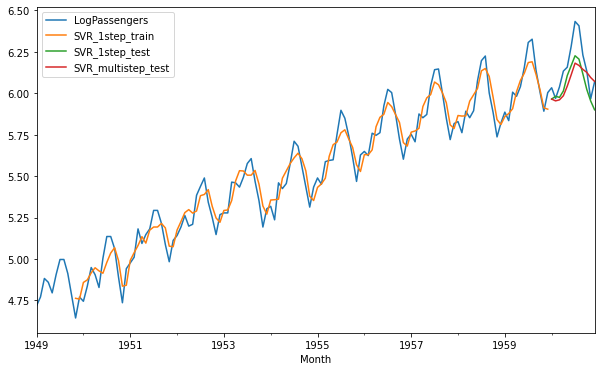

In [ ]:
one_step_multistep_forecast(SVR(), "SVR")

**Support Vector Machine**
Support vector machine does not perform that well, but again, remember that this is without differencing.

One-step forecast: RF
Test MAPE (Multi-Step): 0.03047132628783365


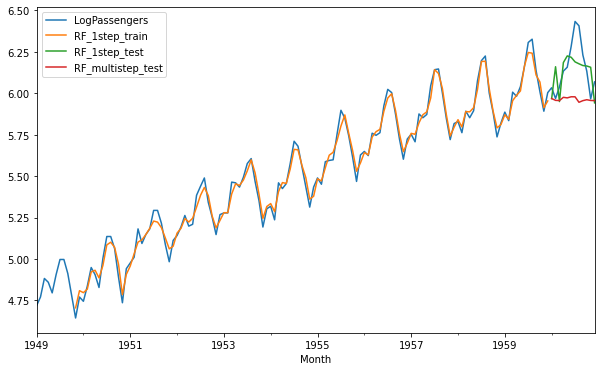

In [ ]:
one_step_multistep_forecast(RandomForestRegressor(), "RF")

**Random Forest**
The predictions are pretty bad, but it does seem to fit very well to the train set, which is pretty common for the random forest.

Next step is to make another function for the multi output forecast, remember that this requires a different model because it has a different number of outputs.

So the basic steps are the same.
Fit the models, store the forecast, compute the map, make apply

In [ ]:
def multi_output_forecast(model, name):
  model.fit(xtrain_m, ytrain_m)

  # save multi-ouput forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      ytest, df.loc[test_idx, f'{name}_multioutput']
  )
  print('Test MAPE (Multi-output):', mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]

  df[cols].plot(figsize=(10, 6));

In [ ]:
multi_output_forecast(SVR(), "SVR") #cannot handle multioutput:
# but you can still train multiple separate SVR

ValueError: ignored

Test MAPE (Multi-output): 0.016423340881601124


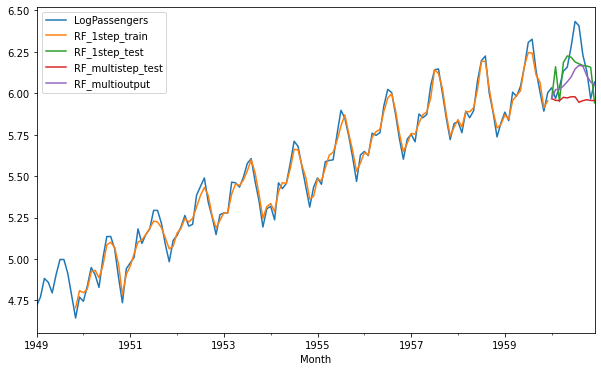

In [ ]:
multi_output_forecast(RandomForestRegressor(), 'RF')

So luckily the random forest works, but again, it doesn't perform too well